In [1]:
# Augmentation.py code
import torch
import torchaudio
import random
import matplotlib.pyplot as plt
import librosa
import librosa.display
from torchaudio import transforms as T
from torchaudio import functional as F



def time_stretch(audio: torch.Tensor, rate: float = 1.0) -> torch.Tensor:
    """Time stretch the audio tensor."""
    # Ensure audio is 2D (channel, time)
    if audio.dim() == 1:
        audio = audio.unsqueeze(0)
    
    # Apply time stretch
    transform = torchaudio.transforms.TimeStretch(n_freq=201, fixed_rate=rate)
    audio = transform(audio.unsqueeze(1))  # Add frequency dimension
    return audio.squeeze(1)  # Remove frequency dimension

def pitch_shift(audio: torch.Tensor, sample_rate: int, n_steps: int = 0) -> torch.Tensor:
    """Pitch shift the audio tensor."""
    transform = torchaudio.transforms.PitchShift(sample_rate=sample_rate, n_steps=n_steps)
    audio = transform(audio)
    return audio
def to_complex_spectrogram(audio: torch.Tensor, n_fft: int = 2048, hop_length: int = 512) -> torch.Tensor:
    """Convert raw wav audio tensor into a raw, complex valued spectrogram."""
    # Ensure audio is 2D (channel, time)
    if audio.dim() == 1:
        audio = audio.unsqueeze(0)

    # Compute the complex spectrogram
    spectrogram = T.Spectrogram(n_fft=n_fft, hop_length=hop_length, power=2)
    audio = spectrogram(audio)
    return audio


def augment(audio: torch.Tensor) -> torch.Tensor:

    # audio = add_gaussian_noise(audio, noise_level=random.uniform(0.001, 0.01))
    audio = pitch_shift(audio, sample_rate=16000, n_steps=random.randint(-2, 2))
    # audio = to_complex_spectrogram(audio)
    # audio = time_stretch(audio, rate=random.uniform(0.9, 1.1))
    return audio

# Function to visualize the augmentations
def plot_waveform(waveform, title="Waveform"):
    plt.figure(figsize=(12, 4))
    plt.plot(waveform.t().numpy())
    plt.title(title)
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.show()

def plot_spectrogram(waveform, title="Spectrogram"):
    spectrogram = librosa.stft(waveform.numpy().squeeze())
    spectrogram_db = librosa.amplitude_to_db(abs(spectrogram))
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(spectrogram_db, sr=16000, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()



In [2]:
# Example usage
# Load a sample audio file (you'll need to provide your own audio file)
waveform, sample_rate = torchaudio.load('C:\\Users\\Sidewinders\\Desktop\\CODE\\UAV_Classification_repo\\src\\.datasets\\UAV_Dataset_9\\Autel_Evo_II\\Autel_Evo_II_1.wav')

# # # Original audio
# # print(waveform.shape)
# plot_waveform(waveform, "Original Waveform")
# plot_spectrogram(waveform, "Original Spectrogram")

# # # Augmented audio
# # print(waveform.shape)
# augmented_waveform = augment(waveform)
# # print(augmented_waveform.shape)
# # plot_waveform(augmented_waveform, "Augmented Waveform")
# plot_spectrogram(augmented_waveform, "Augmented Spectrogram")

# Data Augmentation Expo

### Add gaussian noise


In [3]:
def add_gaussian_noise(audio: torch.Tensor) -> torch.Tensor:
    if audio.dim() == 1:
        audio = audio.unsqueeze(0)
        
    noise = torch.randn_like(audio)
    snr = torch.tensor(random.uniform(10, 30))  # Random SNR between 10 and 30 dB
    print(noise.shape)
    print(audio.shape)
    # noise = noise[:, : waveform.shape[1]]
    
    snr = torch.tensor([20, 10, 3])
    audio = F.add_noise(waveform, noise, snr)
    # audio = F.add_noise(audio, noise, snr_dbs)

    return audio

In [4]:
print(waveform.shape)
print(sample_rate)

torch.Size([1, 220500])
44100


In [5]:
def plot_spectrogram(audio: torch.Tensor, sample_rate: int, title: str = "Spectrogram"):
    # Convert audio tensor to numpy array
    audio_np = audio.numpy().squeeze()

    # Compute the spectrogram
    spectrogram = librosa.stft(audio_np)
    spectrogram_db = librosa.amplitude_to_db(abs(spectrogram))

    # Plot the spectrogram
    plt.figure(figsize=(12, 8))
    librosa.display.specshow(spectrogram_db, sr=sample_rate, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

torch.Size([1, 220500])
torch.Size([1, 220500])


ValueError: For X (1026) and Y (4) with flat shading, A should have shape (3, 1025, 3) or (3, 1025, 4) or (3, 1025) or (3075,), not (3, 1025, 431)

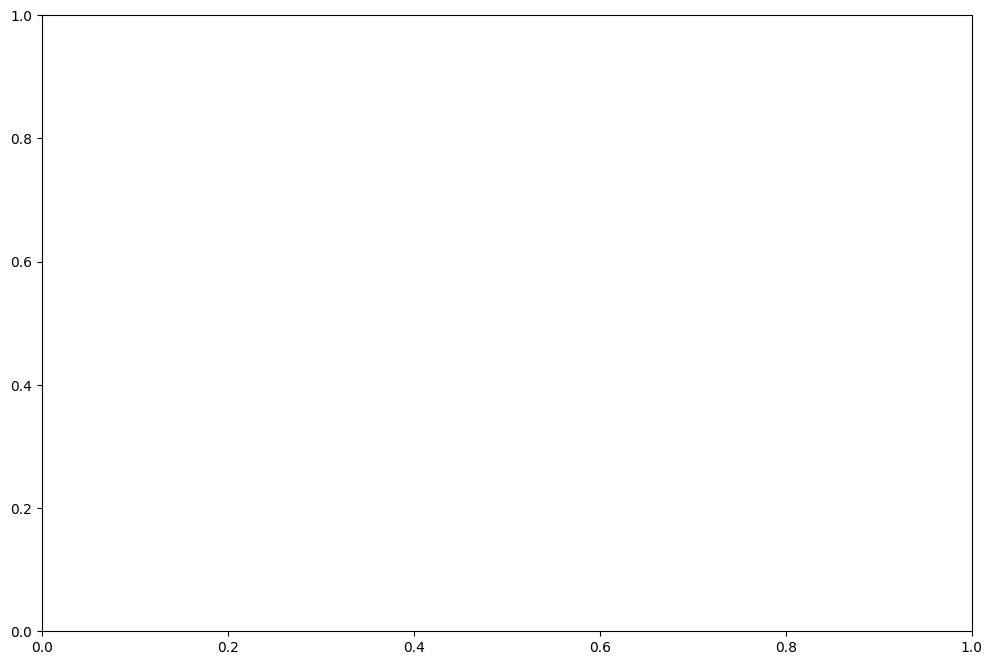

In [6]:
audio = add_gaussian_noise(waveform)

# plot_waveform(add_gaussian_noise(waveform), "Gaussian Noise")
plot_spectrogram(audio, sample_rate=16000, title="Gaussian Noise")


### Dataset normalization
> Normalize sample rate and audio length
This are preset for the UAV audio dataset, obviosly data comes in all shapes and sizes, this should be changed for specific needs. 

In [1]:
import torch
import yaml
from helper.util import AudioDataset, display_random_images
from helper.model import auto_extractor, custom_AST

with open(r'C:\Users\Sidewinders\Desktop\CODE\UAV_Classification_repo\src\config.yaml', 'r') as file:
    config = yaml.safe_load(file)

device = "cuda" if torch.cuda.is_available() else "cpu"

general_config = config['general']
run_config = config['wandb']
data_path = general_config['data_path']
model_name = general_config["model_name"]
feature_extractor = auto_extractor(model_name)

dataset = AudioDataset(data_path, feature_extractor, standardize_audio_boolean=False) # updated class AudioDataset for added normalization

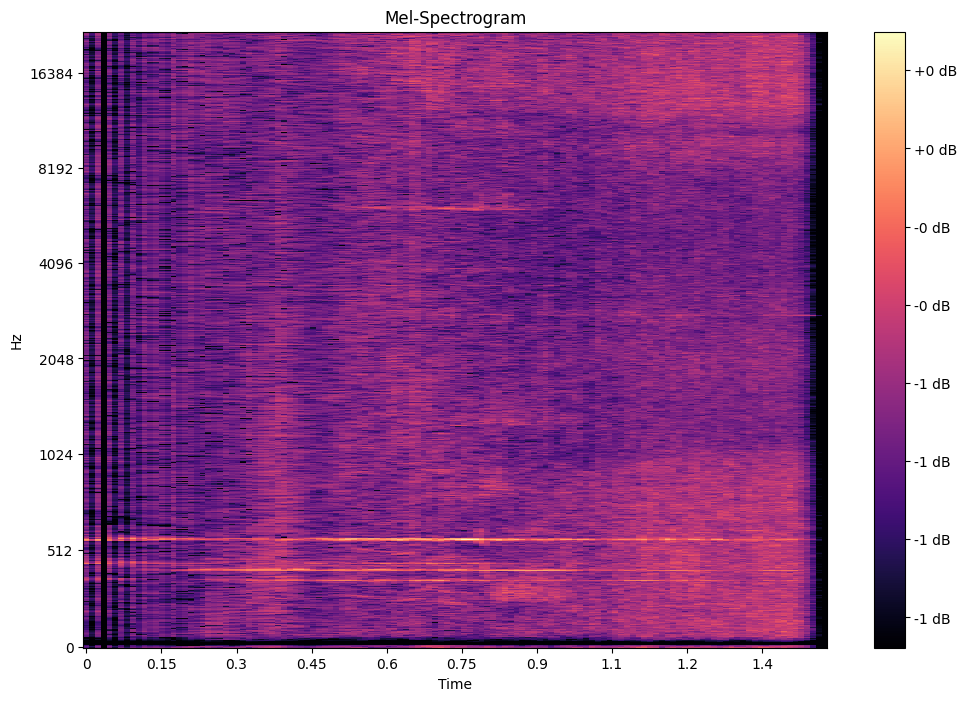

In [12]:
dataset.show_spectrogram(502)

In [13]:
dataset[0][0].shape

torch.Size([1024, 128])

### other useful dataaugmentations
> use only for training data
[link](https://www.sba.org.br/cba2022/wp-content/uploads/artigos_cba2022/paper_5085.pdf)


In [ ]:
# Think about changing from use of subsets to three seperate datasets,
#  also incorporating new data augmentation inside the dataset before being feature extracted